# nanoVLM playground

In [1]:
import re
import torch
import json
import os
import tempfile
from dataclasses import asdict
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_model, save_model

# VANILLA & PREP

## image transforms function

In [3]:
import math
import torch
from torchvision.transforms.functional import resize, InterpolationMode
from einops import rearrange
from typing import Tuple, Union
from PIL import Image


class DynamicResize(torch.nn.Module):
    """
    Resize so that:
      * the longer side ≤ `max_side_len` **and** is divisible by `patch_size`
      * the shorter side keeps aspect ratio and is also divisible by `patch_size`
    Optionally forbids up-scaling.

    Works on PIL Images, (C, H, W) tensors, or (B, C, H, W) tensors.
    Returns the same type it receives.
    """
    def __init__(
        self,
        patch_size: int,
        max_side_len: int,
        resize_to_max_side_len: bool = False,
        interpolation: InterpolationMode = InterpolationMode.BICUBIC,
    ) -> None:
        super().__init__()
        self.p = int(patch_size)
        self.m = int(max_side_len)
        self.interpolation = interpolation
        print(f"Resize to max side len: {resize_to_max_side_len}")
        self.resize_to_max_side_len = resize_to_max_side_len

    # ------------------------------------------------------------
    def _get_new_hw(self, h: int, w: int) -> Tuple[int, int]:
        """Compute target (h, w) divisible by patch_size."""
        long, short = (w, h) if w >= h else (h, w)

        # 1) upscale long side
        target_long = self.m if self.resize_to_max_side_len else min(self.m, math.ceil(long / self.p) * self.p)

        # 2) scale factor
        scale = target_long / long

        # 3) compute short side with ceil → never undershoot
        target_short = math.ceil(short * scale / self.p) * self.p
        target_short = max(target_short, self.p)  # just in case

        return (target_short, target_long) if w >= h else (target_long, target_short)

    # ------------------------------------------------------------
    def forward(self, img: Union[Image.Image, torch.Tensor]):
        if isinstance(img, Image.Image):
            w, h = img.size
            new_h, new_w = self._get_new_hw(h, w)
            return resize(img, [new_h, new_w], interpolation=self.interpolation)

        if not torch.is_tensor(img):
            raise TypeError(
                "DynamicResize expects a PIL Image or a torch.Tensor; "
                f"got {type(img)}"
            )

        # tensor path ---------------------------------------------------------
        batched = img.ndim == 4
        if img.ndim not in (3, 4):
            raise ValueError(
                "Tensor input must have shape (C,H,W) or (B,C,H,W); "
                f"got {img.shape}"
            )

        # operate batch-wise
        imgs = img if batched else img.unsqueeze(0)
        _, _, h, w = imgs.shape
        new_h, new_w = self._get_new_hw(h, w)
        out = resize(imgs, [new_h, new_w], interpolation=self.interpolation)

        return out if batched else out.squeeze(0)


class SplitImage(torch.nn.Module):
    """Split (B, C, H, W) image tensor into square patches.

    Returns:
        patches: (B·n_h·n_w, C, patch_size, patch_size)
        grid:    (n_h, n_w)  - number of patches along H and W
    """
    def __init__(self, patch_size: int) -> None:
        super().__init__()
        self.p = patch_size

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[int, int]]:
        if x.ndim == 3:            # add batch dim if missing
            x = x.unsqueeze(0)

        b, c, h, w = x.shape
        if h % self.p or w % self.p:
            raise ValueError(f'Image size {(h,w)} not divisible by patch_size {self.p}')

        n_h, n_w = h // self.p, w // self.p
        patches = rearrange(x, 'b c (nh ph) (nw pw) -> (b nh nw) c ph pw',
                            ph=self.p, pw=self.p)
        return patches, (n_h, n_w)


class GlobalAndSplitImages(torch.nn.Module):
    def __init__(self, patch_size: int):
        super().__init__()
        self.p = patch_size
        self.splitter = SplitImage(patch_size)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[int, int]]:
        if x.ndim == 3:
            x = x.unsqueeze(0)

        patches, grid = self.splitter(x)

        if grid == (1, 1):
            return patches, grid  # Dont add global patch if there is only one patch

        global_patch = resize(x, [self.p, self.p])
        return torch.cat([global_patch, patches], dim=0), grid

## logits inference helpers

In [7]:
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float('Inf')):
    top_k = min(top_k, logits.size(-1))  # Safety

    if top_k > 0:
        # Remove all tokens with a probability less than the top-k tokens
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits = logits.masked_fill(indices_to_remove, filter_value)

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

        # Remove tokens with cumulative probability above top_p
        sorted_indices_to_remove = cumulative_probs > top_p

        # Always keep the first token
        sorted_indices_to_remove[..., 0] = False
        
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits = logits.masked_fill(indices_to_remove, filter_value)

    return logits

## getter functions to stitch all helpers

In [27]:
from transformers import AutoTokenizer
import torchvision.transforms as transforms

TOKENIZERS_CACHE = {}

def get_tokenizer(name, extra_special_tokens=None, chat_template=None):
    if name not in TOKENIZERS_CACHE:
        tokenizer_init_kwargs = {"use_fast": True}
        if extra_special_tokens is not None:
            tokenizer_init_kwargs["extra_special_tokens"] = extra_special_tokens
        if chat_template is not None:
            tokenizer_init_kwargs["chat_template"] = chat_template
        tokenizer = AutoTokenizer.from_pretrained(name, **tokenizer_init_kwargs,)
        tokenizer.pad_token = tokenizer.eos_token
        TOKENIZERS_CACHE[name] = tokenizer
    return TOKENIZERS_CACHE[name]

def get_image_processor(max_img_size, splitted_image_size, resize_to_max_side_len=False):
    return transforms.Compose([
        DynamicResize(splitted_image_size, max_img_size, resize_to_max_side_len),
        transforms.ToTensor(),
        GlobalAndSplitImages(splitted_image_size),
    ])

def get_image_string(tokenizer, splitted_image_counts, mp_image_token_length):
    image_string = ""
    # splitted_image_counts is a list of tuples (n_h, n_w)
    for idx, (n_h, n_w) in enumerate(splitted_image_counts):
        if len(splitted_image_counts) > 1:
            image_string += f"<image: {idx}>"
        if hasattr(tokenizer, "global_image_token"):
            image_string += tokenizer.global_image_token
            image_string += tokenizer.image_token * mp_image_token_length
            if n_h == 1 and n_w == 1:  # If there is only one patch, treat it as the global image
                continue
        for i in range(n_h):
            for j in range(n_w):
                image_string += getattr(tokenizer, f'r{i+1}c{j+1}')
                image_string += tokenizer.image_token * mp_image_token_length
    return image_string


## model components

### ViT

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/siglip/modeling_siglip.py#L245
class ViTPatchEmbeddings(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.img_size = cfg.vit_img_size
        self.patch_size = cfg.vit_patch_size
        self.num_patches = (self.img_size // self.patch_size) ** 2
        self.cls_flag = cfg.vit_cls_flag
        self.embd_dim = cfg.vit_hidden_dim

        # Conv layer to extract the patches
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=self.embd_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid",
        )

        if self.cls_flag:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embd_dim))
            self.position_embedding = nn.Parameter(torch.rand(1, self.num_patches + 1, self.embd_dim))
        else:
            self.position_embedding = nn.Parameter(torch.rand(1, self.num_patches, self.embd_dim))


    def forward(self, x):
        x = self.conv(x)  # extract patches
        x = x.flatten(2)  # flatten the patches into a single dimension
        x = x.transpose(1, 2)  # transpose to (batch_size, num_patches, hidden_dim)

        # Add CLS token (according to original ViT Paper) and position embeddings
        if self.cls_flag:
            cls_token = self.cls_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        return x

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/siglip/modeling_siglip.py#L381
# https://github.com/karpathy/nanoGPT/blob/master/model.py#L29
class ViTMultiHeadAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.n_heads = cfg.vit_n_heads
        self.embd_dim = cfg.vit_hidden_dim
        assert self.embd_dim % self.n_heads == 0, "embd_dim must be divisible by num_heads"
        self.head_dim = self.embd_dim // self.n_heads
        self.dropout = cfg.vit_dropout

        # Combined projections for all heads
        self.qkv_proj = nn.Linear(self.embd_dim, 3 * self.embd_dim, bias=True)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim, bias=True)

        # Dropout layers
        self.attn_dropout = nn.Dropout(self.dropout)
        self.resid_dropout = nn.Dropout(self.dropout)

        # Use scaled dot product attention if available
        self.sdpa = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.sdpa:
            print("Warning: scaled dot product attention not available. Using standard attention in ViT.")

    def forward(self, x):
        B, T, C = x.size()

        qkv = self.qkv_proj(x)
        q, k, v = qkv.split(C, dim=2)
        # Reshape  [B, T, C] -> [B, T, n_heads, head_dim] and transpose -> [B, n_heads, T, head_dim]
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)

        if self.sdpa:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v, 
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0.0,
                is_causal=False # ViT attention is bidirectional
            )
        else:
            attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            attn = F.softmax(attn, dim=-1)
            attn = self.attn_dropout(attn)
            y = attn @ v  # (B, n_heads, T, T) x (B, n_heads, T, head_dim) -> (B, n_heads, T, head_dim)
        
        # Transpose back from [B, n_heads, T, head_dim] to [B, T, n_heads * head_dim] and combine all heads to [B, T, C]
        y = y.transpose(1, 2).contiguous().view(B, T, C)  
        y = self.out_proj(y)
        y = self.resid_dropout(y)

        return y

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/siglip/modeling_siglip.py#L453
class ViTMLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation_fn = nn.GELU(approximate='tanh')
        self.fc1 = nn.Linear(cfg.vit_hidden_dim, cfg.vit_inter_dim)
        self.fc2 = nn.Linear(cfg.vit_inter_dim, cfg.vit_hidden_dim)
        self.dropout = nn.Dropout(cfg.vit_dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

# https://github.com/karpathy/nanoGPT/blob/master/model.py#L94    
class ViTBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg.vit_hidden_dim, eps=cfg.vit_ln_eps)
        self.attn = ViTMultiHeadAttention(cfg)
        self.ln2 = nn.LayerNorm(cfg.vit_hidden_dim, eps=cfg.vit_ln_eps)
        self.mlp = ViTMLP(cfg)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x
    

class ViT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.patch_embedding = ViTPatchEmbeddings(cfg)
        self.cls_flag = cfg.vit_cls_flag
        self.dropout = nn.Dropout(cfg.vit_dropout)
        self.blocks = nn.ModuleList([ViTBlock(cfg) for _ in range(cfg.vit_n_blocks)])
        self.layer_norm = nn.LayerNorm(cfg.vit_hidden_dim, eps=cfg.vit_ln_eps)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.patch_embedding(x) 
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)

        if self.cls_flag:
            x = self.layer_norm(x[:, 0])
        else:
            x = self.layer_norm(x)
            #x = x.mean(dim=1)
        
        return x

### LM

In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L69
class RMSNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(cfg.lm_hidden_dim))
        self.eps = cfg.lm_rms_eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Compute inverse of RMS: square the tensor element-wise, mean is computed across lm_hidden_dim.
        irms = torch.rsqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps) # inverse of RMS
        x = x * irms * self.weight

        return x

# Multiple derivates of Rotary Embeddings by now, this is a basic one with linear scaling to context length
# e.g. https://github.com/huggingface/smollm/blob/main/vision/m4/models/vllama3/modeling_vllama3.py#L190
class RotaryEmbedding(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg.lm_hidden_dim % cfg.lm_n_heads == 0, "Hidden dimension must be divisible by number of heads"
        
        self.dim = cfg.lm_hidden_dim // cfg.lm_n_heads # dim of each head
        self.base = cfg.lm_re_base
        self.max_seq_len = cfg.lm_max_position_embeddings
        # Standard RoPE implementation - create frequencies for each dimension
        # freq_i = 1 / (base^(2i/dim)) where i is the dimension index
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float() / self.dim))
        self.register_buffer("inv_freq", inv_freq)
        self.original_max_seq_len = cfg.lm_max_position_embeddings
        self.attention_scaling = cfg.lm_attn_scaling

    @torch.no_grad()
    def forward(self, position_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len = position_ids.shape
        # Dynamic scaling for longer sequences
        # Divide the angle frequency to fit more rotation into the embedding space.
        max_seq = position_ids.max() + 1
        if max_seq > self.original_max_seq_len:
            scale = max_seq / self.original_max_seq_len
            inv_freq = self.inv_freq / scale
        else:
            inv_freq = self.inv_freq
            
        # Compute theta = position * frequency
        # Flatten position_ids for batch processing
        flat_position_ids = position_ids.reshape(-1).float()
        
        # Element-wise outer product: [seq_len] x [dim/2] => [seq_len, dim/2]
        freqs = flat_position_ids.unsqueeze(-1) * inv_freq.unsqueeze(0)
        
        # Reshape to include batch dimension
        freqs = freqs.reshape(batch_size, seq_len, -1)
        
        # Now create interleaved pattern
        emb = torch.cat([freqs, freqs], dim=-1)
        
        # Compute cos and sin
        cos = torch.cos(emb) * self.attention_scaling
        sin = torch.sin(emb) * self.attention_scaling
        
        return cos, sin

def rotate_half(x: torch.Tensor) -> torch.Tensor:
    # Rotates the input by dividing the hidden dimension to two, then swapping and negating dimensions.
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

# Apply rotary position embeddings to queries and keys.
def apply_rotary_pos_embd(q: torch.Tensor, k: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor, unsqueeze_dim:int=1)-> tuple[torch.Tensor, torch.Tensor]:
    """
    Applies rotary positional embeddings to query and key tensors in attention mechanisms.

    Rotary positional embeddings inject position-dependent rotations into query and key vectors,
    enabling transformers to encode positional information effectively without explicit positional encoding.

    Args:
        q (torch.Tensor): Query tensor with shape [batch_size, num_heads, seq_len, head_dim].
        k (torch.Tensor): Key tensor with shape [batch_size, num_heads, seq_len, head_dim].
        cos (torch.Tensor): Precomputed cosine positional embeddings with shape [batch_size, seq_len, head_dim].
        sin (torch.Tensor): Precomputed sine positional embeddings with shape [batch_size, seq_len, head_dim].
        unsqueeze_dim (int, optional): Dimension index to unsqueeze `cos` and `sin` to enable broadcasting.
                                      Defaults to 1 (typically the heads dimension).

    Returns:
        tuple[torch.Tensor, torch.Tensor]: The rotated query and key tensors (`q_embed`, `k_embed`), 
                                           each with the same shape as the input tensors.

    How it works:
        - `cos` and `sin` tensors are unsqueezed at `unsqueeze_dim` to broadcast across attention heads.
        - Rotary embeddings apply a complex number rotation in the embedding space using:
            rotated = (original * cos) + (rotate_half(original) * sin)
        - `rotate_half` performs a specific half-dimension rotation on the input tensor.
        - This operation encodes relative position information in q and k without adding explicit positional vectors.

    Example:
        q_embed, k_embed = apply_rotary_pos_embd(q, k, cos, sin)

    """

    # We need to make sure cos and sin can be properly broadcast
    # to the shape of q and k by adding the heads dimension
    cos = cos.unsqueeze(unsqueeze_dim)  # [batch_size, 1, seq_len, head_dim]
    sin = sin.unsqueeze(unsqueeze_dim)  # [batch_size, 1, seq_len, head_dim]
    
    # Apply complex multiplication:
    # (q * cos) + (rotate_half(q) * sin)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L214
# https://github.com/huggingface/smollm/blob/main/vision/m4/models/vllama3/modeling_vllama3.py#L382
class LanguageModelGroupedQueryAttention(nn.Module):
    """
    Implements Grouped Query Attention (GQA) as used in some transformer-based language models.

    GQA reduces computation by using fewer key-value heads than query heads,
    grouping multiple query heads to share the same key-value heads.

    Args:
        cfg: Configuration object containing:
            - lm_n_heads (int): Number of query heads.
            - lm_n_kv_heads (int): Number of key-value heads.
            - lm_hidden_dim (int): Hidden embedding dimension.
            - lm_dropout (float): Dropout rate.
    """
    def __init__(self, cfg):
        super().__init__()

        self.n_heads = cfg.lm_n_heads
        self.n_kv_heads = cfg.lm_n_kv_heads
        self.embd_dim = cfg.lm_hidden_dim
        self.dropout = cfg.lm_dropout

        assert self.n_heads % self.n_kv_heads == 0, "n_heads must be divisible by n_kv_heads"
        assert self.embd_dim % self.n_heads == 0, "embd_dim must be divisible by num_heads"

        self.n_kv_groups = self.n_heads // self.n_kv_heads
        self.head_dim = self.embd_dim // self.n_heads

        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim, bias=False)
        self.k_proj = nn.Linear(self.embd_dim, self.head_dim * self.n_kv_heads, bias=False)
        self.v_proj = nn.Linear(self.embd_dim, self.head_dim * self.n_kv_heads, bias=False)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.dropout)
        self.resid_dropout = nn.Dropout(self.dropout)

        # Use scaled dot product attention if available
        self.sdpa = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.sdpa:
            print("Warning: scaled dot product attention not available, using standard attention in LM.")

    def forward(self, x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor, attention_mask=None, block_kv_cache=None) -> tuple[torch.Tensor, dict]:
        """
        Forward pass for grouped query attention.

        Args:
            x (Tensor): Input tensor of shape (B, T_curr, C), where
                        B = batch size,
                        T_curr = current sequence length,
                        C = embedding dimension.
            cos (Tensor): Rotary embedding cosines, shape compatible with q and k.
            sin (Tensor): Rotary embedding sines, shape compatible with q and k.
            attention_mask (Tensor, optional): Attention mask tensor of shape (B, total_kv_length),
                                               with 1 for tokens to attend to and 0 for padding.
            block_kv_cache (dict, optional): Cache dict with 'key' and 'value' tensors for autoregressive decoding.

        Returns:
            tuple[Tensor, dict]:
                - Output tensor after attention and projection, shape (B, T_curr, C).
                - Updated block_kv_cache dict for caching key-value states.
        """
        is_prefill = block_kv_cache is None

        B, T_curr, C = x.size() # T_curr is the sequence length of the current input x

        q_curr = self.q_proj(x).view(B, T_curr, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T_curr, head_dim)
        k_curr = self.k_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)
        v_curr = self.v_proj(x).view(B, T_curr, self.n_kv_heads, self.head_dim).transpose(1, 2) # (B, n_kv_heads, T_curr, head_dim)

        # Apply rotary embeddings to the current q and k
        q, k_rotated = apply_rotary_pos_embd(q_curr, k_curr, cos, sin)

        # Check if we can use cached keys and values
        if not is_prefill and block_kv_cache['key'] is not None:
            # Concatenate with cached K, V
            # k_rotated and v_curr are for the new token(s)
            k = block_kv_cache['key']
            v = block_kv_cache['value']
            k = torch.cat([k, k_rotated], dim=2)
            v = torch.cat([v, v_curr], dim=2)
            block_kv_cache['key'] = k
            block_kv_cache['value'] = v
        else:
            # No cache, this is the first pass (prefill)
            k = k_rotated
            v = v_curr
            block_kv_cache = {'key': k, 'value': v}

        # Repeat K, V for Grouped Query Attention
        k_exp = k.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
        v_exp = v.repeat_interleave(self.n_kv_groups, dim=1) # (B, n_heads, T_kv, head_dim)
        
        T_kv = k_exp.size(2) # Total sequence length of keys/values

        # Prepare attention mask for SDPA or manual path
        # attention_mask is (B, T_kv_total_length), 1 for attend, 0 for pad
        additive_attn_mask = None
        if attention_mask is not None:
            # The current `attention_mask` parameter is assumed to be `[B, total_sequence_length_kv]`
            # Let's make it `[B, 1, 1, T_kv]` for SDPA.
            mask_for_keys = attention_mask[:, :T_kv] # Ensure mask matches key length [B, T_kv]
            additive_attn_mask = (1.0 - mask_for_keys.unsqueeze(1).unsqueeze(2).float()) * torch.finfo(q.dtype).min
            # This additive_attn_mask shape is [B, 1, 1, T_kv]

        if self.sdpa and x.device.type != 'mps':
            # During decode, no additional masking needed as [1, T_kv] is naturally causal
            is_causal = (T_curr == T_kv and T_curr > 1)
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k_exp, v_exp,
                attn_mask=additive_attn_mask, 
                dropout_p=self.dropout if self.training else 0.0,
                is_causal=is_causal
            )
        else:
            # Manual attention implementation
            attn = torch.matmul(q, k_exp.transpose(2, 3)) / math.sqrt(self.head_dim) # (B, n_heads, T_curr, T_kv)
            # During decode: no additional masking needed as [1, T_kv] is naturally causal
            if T_curr == T_kv and T_curr > 1:
                causal_mask_val = torch.tril(torch.ones(T_curr, T_curr, device=x.device, dtype=torch.bool)).view(1, 1, T_curr, T_curr)
                attn = attn.masked_fill(~causal_mask_val, float('-inf'))

            if additive_attn_mask is not None: # Additive padding mask
                # additive_attn_mask is [B,1,1,T_kv], needs to be broadcast to [B, n_heads, T_curr, T_kv]
                attn = attn + additive_attn_mask 

            attn = F.softmax(attn, dim=-1)
            attn = self.attn_dropout(attn)
            y = attn @ v_exp
            
        y = y.transpose(1, 2).contiguous().view(B, T_curr, C)
        y = self.out_proj(y)
        y = self.resid_dropout(y)

        return y, block_kv_cache

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L160
class LanguageModelMLP(nn.Module):
    """
    Implements the feed-forward network (MLP) block used in transformer-based language models.

    This MLP uses a gated activation mechanism where two separate linear projections
    are applied to the input: one passed through an activation function (gate_proj),
    and the other as is (up_proj). Their element-wise product is then projected back
    to the embedding dimension (down_proj).

    Args:
        cfg: Configuration object containing:
            - lm_hidden_dim (int): The embedding dimension size.
            - lm_inter_dim (int): The intermediate dimension size for the MLP.

    Attributes:
        activation_fn (Callable): The activation function used (SiLU).
        gate_proj (nn.Linear): Linear projection for gating pathway.
        up_proj (nn.Linear): Linear projection for upscaling pathway.
        down_proj (nn.Linear): Linear projection for downscaling back to embedding dim.
    """

    def __init__(self, cfg):
        super().__init__()
        self.embd_dim = cfg.lm_hidden_dim
        self.inter_dim = cfg.lm_inter_dim

        self.activation_fn = F.silu
        self.gate_proj = nn.Linear(self.embd_dim, self.inter_dim, bias=False)
        self.up_proj = nn.Linear(self.embd_dim, self.inter_dim, bias=False)
        self.down_proj = nn.Linear(self.inter_dim, self.embd_dim, bias=False)

    def forward(self, x):
        """
        Forward pass through the gated MLP block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, embd_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, seq_length, embd_dim),
                    after gated MLP transformation.
        """
        gate = self.activation_fn(self.gate_proj(x))
        x = self.up_proj(x)
        x = self.down_proj(gate * x)

        return x

# https://github.com/meta-llama/llama3/blob/main/llama/model.py#L222
class LanguageModelBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = LanguageModelMLP(cfg)
        self.attn = LanguageModelGroupedQueryAttention(cfg)
        self.norm1 = RMSNorm(cfg) # Input Norm
        self.norm2 = RMSNorm(cfg) # Post Attention Norm
    
    def forward(self, x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor, attention_mask: torch.Tensor=None, block_kv_cache: dict=None):
        """
        Forward pass of the Transformer block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, hidden_dim).
            cos (Tensor): Cosine positional embeddings for rotary embedding, shape
                matching sequence length and head dimension.
            sin (Tensor): Sine positional embeddings for rotary embedding, same shape as cos.
            attention_mask (Tensor, optional): Attention mask of shape (batch_size, total_kv_length),
                with 1 indicating tokens to attend to and 0 for padding tokens.
            block_kv_cache (dict, optional): Key-value cache dict for cached keys and values
                during decoding. If None, no cache is used.

        Returns:
            Tuple[Tensor, dict]: Output tensor after the block (same shape as input),
                and the updated key-value cache dictionary.
        """
        res = x
        x = self.norm1(x)
        x, block_kv_cache = self.attn(x, cos, sin, attention_mask, block_kv_cache)
        x = res + x

        res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = res + x

        return x, block_kv_cache

# https://github.com/meta-llama/llama3/blob/main/llama/model.py#L251
class LanguageModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.lm_use_tokens = cfg.lm_use_tokens
        self.lm_tie_weights = cfg.lm_tie_weights

        self.token_embedding = nn.Embedding(cfg.lm_vocab_size, cfg.lm_hidden_dim)
        self.rotary_embd = RotaryEmbedding(cfg)
        self.blocks = nn.ModuleList([
            LanguageModelBlock(cfg) for _ in range(cfg.lm_n_blocks)
        ])
        self.norm = RMSNorm(cfg) # Final Norm
        self.head = nn.Linear(cfg.lm_hidden_dim, cfg.lm_vocab_size, bias=False)
        if self.lm_tie_weights:
            self.head.weight = self.token_embedding.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            module.weight.data.fill_(1.0)

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor=None, kv_cache: list[dict]=None, start_pos: int=0):
        """
        Performs a forward pass through the language model.

        Args:
            x (Tensor): Input tensor. If `lm_use_tokens` is True, this should be
                token indices with shape (batch_size, sequence_length).
                If False, it should be embeddings of shape (batch_size, sequence_length, hidden_dim).
            attention_mask (Tensor, optional): Mask tensor for attention to
                specify which tokens to attend to, typically of shape
                (batch_size, sequence_length). Default is None.
            kv_cache (list[dict], optional): List of key-value caches for each transformer
                block to enable efficient autoregressive decoding.
                If None, no cache is used and new ones are created. Default is None.
            start_pos (int, optional): The starting position index for the current input
                sequence. Used to compute rotary positional embeddings correctly,
                especially for cached sequences during generation. Default is 0.

        Returns:
            Tuple:
                - Tensor: Output logits with shape (batch_size, sequence_length, vocab_size)
                if `lm_use_tokens` is True, otherwise the hidden state embeddings
                (batch_size, sequence_length, hidden_dim).
                - list: Updated list of key-value caches, one for each transformer block,
                useful for autoregressive decoding and incremental generation.

        Behavior:
            - If `lm_use_tokens` is True, the input token indices are first embedded.
            - Rotary positional embeddings are generated for the current input positions,
            which are passed along to each transformer block.
            - For each transformer block, the input is processed along with
            rotary embeddings, attention mask, and optional cached key-values.
            - After processing all blocks, a final RMS normalization is applied.
            - If tokens are used, the normalized hidden states are projected to logits
            over the vocabulary.
            - The method returns the logits or embeddings along with the updated
            cache for efficient decoding.
        """
        if self.lm_use_tokens:
            x = self.token_embedding(x)

        # T_curr is the length of the current input sequence
        B, T_curr, _ = x.size()
        
        # Create position_ids for the current sequence based on start_pos
        current_position_ids = torch.arange(start_pos, start_pos + T_curr, device=x.device).unsqueeze(0).expand(B, -1)
        cos, sin = self.rotary_embd(current_position_ids) # Get rotary position embeddings for current tokens

        # Initialize new KV cache if none provided
        if kv_cache is None:
            kv_cache = [None] * len(self.blocks)

        for i, block in enumerate(self.blocks):
            x, kv_cache[i] = block(x, cos, sin, attention_mask, kv_cache[i])

        x = self.norm(x)

        # Compute logits if we are using tokens, otherwise stay in the embedding space
        if self.lm_use_tokens: 
            x = self.head(x) 

        return x, kv_cache


    @torch.inference_mode()
    def generate(self, inputs: torch.Tensor, max_new_tokens: int=20):
        """
        Generate tokens autoregressively from a given input sequence.

        Args:
            inputs (torch.Tensor): Input tensor containing token indices or embeddings.
                Shape: (batch_size, sequence_length) or (sequence_length,) for a single sequence.
            max_new_tokens (int): Number of new tokens to generate after the input sequence.

        Returns:
            torch.Tensor: The generated sequence, including the original inputs and newly generated tokens.
                Shape: (batch_size, sequence_length + max_new_tokens)
        """
        # Add batch dimension if needed
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)
        generated_outputs = inputs.clone()

        prompt_output, kv_cache_list = self.forward(
            generated_outputs, 
            attention_mask=None,
            kv_cache=None,
            start_pos=0
        )
        last_output = prompt_output[:, -1, :]

        # Decode Phase with KV cache
        for i in range(max_new_tokens):
            if self.lm_use_tokens:
                # Now the model outputs logits
                next_output = torch.argmax(last_output, dim=-1, keepdim=True)
            else:
                # Now the model outputs embeddings
                next_output = last_output.unsqueeze(1)

            generated_outputs = torch.cat((generated_outputs, next_output), dim=1)
            
            # The token being processed is `next_token`. Its position is `generated_outputs.size(1) - 1`.
            current_token_start_pos = generated_outputs.size(1) - 1

            if i == max_new_tokens - 1: 
                break

            decode_step_output, kv_cache_list = self.forward(
                next_output, 
                attention_mask=None,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
            last_output = decode_step_output[:, -1, :] 
    
        return generated_outputs

### MLP Proj.

In [10]:
# Modality Projection from Vision to Language
import torch.nn as nn

class ModalityProjector(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.input_dim = cfg.vit_hidden_dim * (cfg.mp_pixel_shuffle_factor**2)
        self.output_dim = cfg.lm_hidden_dim
        self.scale_factor = cfg.mp_pixel_shuffle_factor

        self.proj = nn.Linear(self.input_dim, self.output_dim, bias=False)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(self.proj.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    # https://github.com/huggingface/smollm/blob/main/vision/m4/models/vllama3/modeling_vllama3.py#L1281
    def pixel_shuffle(self, x):
        bsz, seq, embed_dim = x.size()
        seq_root = int(seq**0.5)
        assert seq_root**2 == seq # Sequence length must be a perfect square for pixel shuffle
        assert seq_root % self.scale_factor == 0 # Sequence root must be divisible by scale factor

        height = width = seq_root
        x = x.view(bsz, height, width, embed_dim)
        h_out = height // self.scale_factor
        w_out = width // self.scale_factor
        
        x = x.reshape(bsz, h_out, self.scale_factor, w_out, self.scale_factor, embed_dim)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.reshape(bsz, h_out * w_out, embed_dim * self.scale_factor**2)
        
        return x

    def forward(self, x):
        x = self.pixel_shuffle(x)
        x = self.proj(x)

        return x

### Config

In [13]:
from dataclasses import dataclass, field


@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 512
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip2-base-patch16-512'

    lm_hidden_dim: int = 960
    lm_inter_dim: int = 2560
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_base_vocab_size: int = 49152
    extra_token_amount: int = 66  # Number of extra tokens for the VLM (image start, image end, image token)
    lm_vocab_size: int = lm_base_vocab_size + extra_token_amount # Not a great way to do this, but it works for now (vlm_extra_tokens cannot be a dict, since this is mutable, and a Field has no len() function)
    lm_n_heads: int = 15
    lm_n_kv_heads: int = 5
    lm_dropout: float = 0.0
    lm_n_blocks: int = 32
    lm_attn_scaling: float = 1.0
    lm_max_length: int = 8192
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M-Instruct' #'HuggingFaceTB/SmolLM2-135M' #
    lm_tokenizer: str = 'HuggingFaceTB/SmolLM2-135M-Instruct'
    lm_chat_template: str = "{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

    mp_pixel_shuffle_factor: int = 4
    mp_image_token_length: int = 64

    max_img_size: int = 2048
    resize_to_max_side_len: bool = True

    vlm_extra_tokens: dict[str, str] = field(default_factory=lambda: {"image_token": "<|image|>", "global_image_token": "<|global_image|>",
      "r1c1": "<row_1_col_1>", "r1c2": "<row_1_col_2>", "r1c3": "<row_1_col_3>", "r1c4": "<row_1_col_4>", "r1c5": "<row_1_col_5>", "r1c6": "<row_1_col_6>", "r1c7": "<row_1_col_7>", "r1c8": "<row_1_col_8>",
      "r2c1": "<row_2_col_1>", "r2c2": "<row_2_col_2>", "r2c3": "<row_2_col_3>", "r2c4": "<row_2_col_4>", "r2c5": "<row_2_col_5>", "r2c6": "<row_2_col_6>", "r2c7": "<row_2_col_7>", "r2c8": "<row_2_col_8>",
      "r3c1": "<row_3_col_1>", "r3c2": "<row_3_col_2>", "r3c3": "<row_3_col_3>", "r3c4": "<row_3_col_4>", "r3c5": "<row_3_col_5>", "r3c6": "<row_3_col_6>", "r3c7": "<row_3_col_7>", "r3c8": "<row_3_col_8>",
      "r4c1": "<row_4_col_1>", "r4c2": "<row_4_col_2>", "r4c3": "<row_4_col_3>", "r4c4": "<row_4_col_4>", "r4c5": "<row_4_col_5>", "r4c6": "<row_4_col_6>", "r4c7": "<row_4_col_7>", "r4c8": "<row_4_col_8>",
      "r5c1": "<row_5_col_1>", "r5c2": "<row_5_col_2>", "r5c3": "<row_5_col_3>", "r5c4": "<row_5_col_4>", "r5c5": "<row_5_col_5>", "r5c6": "<row_5_col_6>", "r5c7": "<row_5_col_7>", "r5c8": "<row_5_col_8>",
      "r6c1": "<row_6_col_1>", "r6c2": "<row_6_col_2>", "r6c3": "<row_6_col_3>", "r6c4": "<row_6_col_4>", "r6c5": "<row_6_col_5>", "r6c6": "<row_6_col_6>", "r6c7": "<row_6_col_7>", "r6c8": "<row_6_col_8>",
      "r7c1": "<row_7_col_1>", "r7c2": "<row_7_col_2>", "r7c3": "<row_7_col_3>", "r7c4": "<row_7_col_4>", "r7c5": "<row_7_col_5>", "r7c6": "<row_7_col_6>", "r7c7": "<row_7_col_7>", "r7c8": "<row_7_col_8>",
      "r8c1": "<row_8_col_1>", "r8c2": "<row_8_col_2>", "r8c3": "<row_8_col_3>", "r8c4": "<row_8_col_4>", "r8c5": "<row_8_col_5>", "r8c6": "<row_8_col_6>", "r8c7": "<row_8_col_7>", "r8c8": "<row_8_col_8>"})
    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints'
    hf_repo_name: str = 'nanoVLM'


@dataclass
class TrainConfig:
    lr_mp: float = 0.00512
    lr_vision_backbone: float = 5e-5 #0.0005 #
    lr_language_backbone: float = 5e-5 #0
    data_cutoff_idx: int = None
    val_ratio: float = 0.005
    batch_size: int = 1
    gradient_accumulation_steps: int = 8
    max_grad_norm: float = 1.0
    eval_in_epochs: bool = True
    eval_interval: int = 500
    stats_log_interval: int = 100
    max_training_steps: int = 80100
    max_images_per_example: int = 8
    max_images_per_knapsack: int = 36
    max_sample_length: int = 8192
    compile: bool = False
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = '/fsx/luis_wiedmann/datasets/asterix_rated'
    train_dataset_name: tuple[str, ...] = ("all", ) #('allava_laion', 'allava_vflan', 'cambrian(filtered)_processed', 'LLaVA_Instruct_150K', 'mmevol', 'sharegpt4o', 'sharegpt4v(coco)', 'sharegpt4v(knowledge)', 'sharegpt4v(llava)', 'sharegpt4v(sam)') # 'vision_flan(filtered)', 'lvis_instruct4v',
    relevance_min_rating: int = 1
    image_correspondence_min_rating: int = 1
    visual_dependency_min_rating: int = 1
    formatting_min_rating: int = 1
    wandb_entity: str = "HuggingFace" # Indicate the entity to log to in wandb
    log_wandb: bool = True
    use_lmms_eval: bool = True # Use lmms-eval for evaluation
    lmms_eval_tasks: str = 'mmstar,mmmu,ocrbench,textvqa,docvqa,scienceqa,mme,infovqa' # Pass additional task as one string, seperated by commas without spaces (e.g. 'mmstar,mmmu,ocrbench')
    lmms_eval_limit: float = None
    lmms_eval_batch_size: int = 64


### VLM

In [41]:
import json
import os
import tempfile
from dataclasses import asdict
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_model, save_model

class VisionLanguageModel(nn.Module):
    def __init__(self, cfg: VLMConfig, load_backbone=True):
        super().__init__()
        self.cfg = cfg
        if load_backbone:
            print("Loading from backbone weights")
            self.vision_encoder = ViT.from_pretrained(cfg)
            self.decoder = LanguageModel.from_pretrained(cfg)
        else:
            self.vision_encoder = ViT(cfg)
            self.decoder = LanguageModel(cfg)
        self.MP = ModalityProjector(cfg)
        self.load_backbone = load_backbone
        self.tokenizer = get_tokenizer(cfg.lm_tokenizer, cfg.vlm_extra_tokens, cfg.lm_chat_template)

    def _replace_img_tokens_with_embd(self, input_ids, token_embd, image_embd):
        """
        Replace every image-token placeholder in `input_ids` with the corresponding slice
        from `image_embd`. Supports an arbitrary number of image-token placeholders per sample.
        The first example in the batch might have 2 images and the second none.
        """
        # Clone the original embeddings to avoid in-place issues
        updated_token_embd = token_embd.clone()

        # Build a mask of all image-token positions: shape [B, T_seq]
        mask = (input_ids == self.tokenizer.image_token_id)
        updated_token_embd[mask] = image_embd.view(-1, image_embd.size(-1)).to(updated_token_embd.dtype) # torch flattens before assigning

        return updated_token_embd

    def _process_images(self, images, device):
        if isinstance(images, list):
            if images and isinstance(images[0], list):
                images = [img for sublist in images for img in sublist]

            if not images:  # Handle cases with no images
                return None
            else:
                return torch.cat(images, dim=0).to(device)
        return images # Already a tensor

    def forward(self, input_ids, images, attention_mask=None, targets=None):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids) # [B, T_sequence, D_lm]

        if images_tensor is not None:
            image_embd = self.vision_encoder(images_tensor)
            image_embd = self.MP(image_embd)  # [num_images, mp_image_token_length, D_lm]
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)

        logits, _ = self.decoder(token_embd, attention_mask=attention_mask)

        loss = None
        if targets is not None:
            logits = self.decoder.head(logits) # Apply LM head
            # Loss is calculated over all tokens, but `targets` (labels) will have -100 for non-answer tokens.
            # No need to slice logits based on image embedding size here, as the target mask handles it.
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-100)

        return logits, loss

    @torch.inference_mode()
    def generate(self, input_ids, images, attention_mask=None, max_new_tokens=5, top_k=50, top_p=0.9, temperature=0.5, greedy=False):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids) # [B, T_prompt_text, D_lm]

        if images_tensor is not None:
            # 1. Process image if present
            image_embd = self.vision_encoder(images_tensor) # [B, T_img_feat, D_model]
            image_embd = self.MP(image_embd)      # [B, mp_image_token_length, D_lm]
            # 2. Combine image and text embeddings
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)

        current_total_seq_len = token_embd.size(1)
        batch_size = input_ids.size(0) # Or token_embd.size(0)
        
        # --- Multimodal Prefill Phase ---
        prefill_output, kv_cache_list = self.decoder(
            token_embd,
            attention_mask=attention_mask, # Use the provided attention mask
            kv_cache=None,
            start_pos=0
        )
        
        last_token_output_from_prefill = prefill_output[:, -1, :] 
        
        if not self.decoder.lm_use_tokens:
            current_logits = self.decoder.head(last_token_output_from_prefill) 
        else:
            current_logits = last_token_output_from_prefill 

        # Store newly generated token IDs
        newly_generated_ids_list = []

        # --- Decode Phase by sampling tokens autoregressively using the kv-cache ---
        for _ in range(max_new_tokens):
            if greedy:
                next_token_id = torch.argmax(current_logits, dim=-1, keepdim=True)
            else:
                filtered_logits = top_k_top_p_filtering(current_logits, top_k=top_k, top_p=top_p)
                probs = torch.softmax(filtered_logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)
            
            newly_generated_ids_list.append(next_token_id)
            
            # Embed the newly generated token
            next_token_embed = self.decoder.token_embedding(next_token_id) # [B, 1, D_lm]
            
            # The start_pos for the new token is the current total sequence length *before* adding this new token
            current_token_start_pos = current_total_seq_len
            current_total_seq_len += 1

            # update attention mask
            if attention_mask is not None:
                attention_mask = torch.cat((attention_mask, torch.ones((batch_size, 1), device=attention_mask.device, dtype=attention_mask.dtype)), dim=1)

            # With KV cache: only process the new token
            decode_step_output, kv_cache_list = self.decoder(
                next_token_embed,
                attention_mask=attention_mask,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
      
            last_token_output = decode_step_output[:, -1, :] 
            
            # Apply head to get logits (if model is in embedding mode)
            if not self.decoder.lm_use_tokens:
                current_logits = self.decoder.head(last_token_output)
            else:
                current_logits = last_token_output
        
        if not newly_generated_ids_list: # Handle case where max_new_tokens might be 0
            return torch.empty((batch_size,0), dtype=torch.long, device=input_ids.device)

        generated_ids = torch.cat(newly_generated_ids_list, dim=1)

        # Post-process to handle EOS token.
        if self.tokenizer.eos_token_id is not None and generated_ids.numel() > 0: # Ensure generated_ids is not empty
            seq_len = generated_ids.size(1)
            device = generated_ids.device

            eos_mask = (generated_ids == self.tokenizer.eos_token_id) # Create a boolean mask for EOS tokens

            col_indices_for_min = torch.arange(seq_len, device=device) # Create column indices [0, 1, ..., seq_len-1]
            
            # In eos_mask, mark positions with actual col_idx, others with a large number
            masked_col_indices = torch.where(eos_mask, col_indices_for_min.unsqueeze(0).expand_as(generated_ids), seq_len + 1) 

            first_eos_indices_values = torch.min(masked_col_indices, dim=1).values
            
            # Clamp values to seq_len (if no EOS found, min will be seq_len + 1, clamp brings it to seq_len0. This means if no EOS, or EOS is the last token, no replacement will happen for that sample.
            actual_first_eos_indices = torch.clamp(first_eos_indices_values, max=seq_len)

            # Create column indices for comparison, shape [batch_size, seq_len]
            col_indices_for_comparison = torch.arange(seq_len, device=device).unsqueeze(0).expand_as(generated_ids)
            
            # Tokens are replaced if their column index is greater than the index of the first EOS token
            replace_mask = col_indices_for_comparison > actual_first_eos_indices.unsqueeze(1)
            
            generated_ids[replace_mask] = self.tokenizer.eos_token_id
        
        return generated_ids

    def save_pretrained(self, save_directory: str) -> None:
        """
        Save the model and configuration to a directory.

        Args:
            save_directory (str): The directory to save the model and config.
        """
        # Create directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)

        # Save config
        with open(os.path.join(save_directory, "config.json"), "w") as f:
            f.write(json.dumps(asdict(self.cfg), indent=4))

        # Save weights as safetensors
        save_model(self, os.path.join(save_directory, "model.safetensors"))

## Dry Run Vanilla

In [ ]:
import torch

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
DEVICE

'mps'

In [18]:
cfg = VLMConfig()
model = VisionLanguageModel(cfg, load_backbone=False)
model.to(DEVICE)

VisionLanguageModel(
  (vision_encoder): ViT(
    (patch_embedding): ViTPatchEmbeddings(
      (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x ViTBlock(
        (ln1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): ViTMultiHeadAttention(
          (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): ViTMLP(
          (activation_fn): GELU(approximate='tanh')
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
   

In [35]:
from PIL import Image

# Get tokenizer and image processor from model config
tokenizer = get_tokenizer(model.cfg.lm_tokenizer, model.cfg.vlm_extra_tokens, model.cfg.lm_chat_template)
resize_to_max_side_len = False
if hasattr(model.cfg, "resize_to_max_side_len"):
    resize_to_max_side_len = model.cfg.resize_to_max_side_len
image_processor = get_image_processor(model.cfg.max_img_size, model.cfg.vit_img_size, resize_to_max_side_len)

# Load and process the image
img = Image.open("../files/image.png").convert("RGB")
processed_image, splitted_image_ratio = image_processor(img)
if not hasattr(tokenizer, "global_image_token") and splitted_image_ratio[0]*splitted_image_ratio[1] == len(processed_image) - 1:
    # If the tokenizer doesn't have a global image token, but the processor generated it, remove it
    print("Removing global image token")
    processed_image = processed_image[1:]

# Create the image string and prompt
image_string = get_image_string(tokenizer, [splitted_image_ratio], model.cfg.mp_image_token_length)
prompt = "Describe the following image:"

messages = [{"role": "user", "content": image_string + prompt}]
encoded_prompt = tokenizer.apply_chat_template([messages], tokenize=True, add_generation_prompt=True)
tokens = torch.tensor(encoded_prompt).to(DEVICE)
img_t = processed_image.to(DEVICE)

with torch.no_grad():
    generated_ids = model.generate(tokens, img_t, max_new_tokens=20)

output_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

Resize to max side len: True


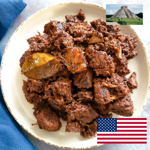

" de text='fm Oncology capturing capturing blo='=' banks de accompaniment JasonHEAD lender marketed inhibitoryTab introspection"

In [37]:
from IPython.display import display

display(img.resize((150,150)))
display(output_text)

# TWIN TOWER

In [42]:
import json
import os
import tempfile
from dataclasses import asdict
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_model, save_model

class VisionLanguageModel(nn.Module):
    def __init__(self, cfg: VLMConfig, load_backbone=True):
        super().__init__()
        self.cfg = cfg
        # if load_backbone:
        #     print("Loading from backbone weights")
        #     self.vision_encoder = ViT.from_pretrained(cfg)
        #     self.decoder = LanguageModel.from_pretrained(cfg)
        # else:
        self.vision_encoder = ViT(cfg)
        self.decoder = LanguageModel(cfg)
        self.MP = ModalityProjector(cfg)
        self.load_backbone = load_backbone
        self.tokenizer = get_tokenizer(cfg.lm_tokenizer, cfg.vlm_extra_tokens, cfg.lm_chat_template)

    def _replace_img_tokens_with_embd(self, input_ids, token_embd, image_embd):
        """
        Replace every image-token placeholder in `input_ids` with the corresponding slice
        from `image_embd`. Supports an arbitrary number of image-token placeholders per sample.
        The first example in the batch might have 2 images and the second none.
        """
        # Clone the original embeddings to avoid in-place issues
        updated_token_embd = token_embd.clone()

        # Build a mask of all image-token positions: shape [B, T_seq]
        mask = (input_ids == self.tokenizer.image_token_id)
        updated_token_embd[mask] = image_embd.view(-1, image_embd.size(-1)).to(updated_token_embd.dtype) # torch flattens before assigning

        return updated_token_embd

    def _process_images(self, images, device):
        if isinstance(images, list):
            if images and isinstance(images[0], list):
                images = [img for sublist in images for img in sublist]

            if not images:  # Handle cases with no images
                return None
            else:
                return torch.cat(images, dim=0).to(device)
        return images # Already a tensor

    def forward(self, input_ids, images, attention_mask=None, targets=None):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids) # [B, T_sequence, D_lm]

        if images_tensor is not None:
            image_embd = self.vision_encoder(images_tensor)
            image_embd = self.MP(image_embd)  # [num_images, mp_image_token_length, D_lm]
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)

        logits, _ = self.decoder(token_embd, attention_mask=attention_mask)

        loss = None
        if targets is not None:
            logits = self.decoder.head(logits) # Apply LM head
            # Loss is calculated over all tokens, but `targets` (labels) will have -100 for non-answer tokens.
            # No need to slice logits based on image embedding size here, as the target mask handles it.
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-100)

        return logits, loss

    def extract_image_features(self, input_ids, images, attention_mask=None):
        """
        Extract image features from the VLM tower for use in the twin tower architecture.
        Returns the processed image embeddings that can be used by the second tower.
        
        Shape flow:
        - images_tensor: [num_images, C, H, W] -> vision encoder
        - image_embd: [num_images, patch_tokens, D_vision] -> modality projector
        - final output: [num_images, mp_image_token_length, D_lm]
        """
        images_tensor = self._process_images(images, input_ids.device)
        
        if images_tensor is None:
            return None
            
        # Process images through vision encoder and modality projector
        image_embd = self.vision_encoder(images_tensor)  # [num_images, patch_tokens, D_vision]
        image_embd = self.MP(image_embd)  # [num_images, mp_image_token_length, D_lm]
        
        return image_embd

    @torch.inference_mode()
    def generate(self, input_ids, images, attention_mask=None, max_new_tokens=5, top_k=50, top_p=0.9, temperature=0.5, greedy=False):
        images_tensor = self._process_images(images, input_ids.device)
        token_embd = self.decoder.token_embedding(input_ids) # [B, T_prompt_text, D_lm]

        if images_tensor is not None:
            # 1. Process image if present
            image_embd = self.vision_encoder(images_tensor) # [B, T_img_feat, D_model]
            image_embd = self.MP(image_embd)      # [B, mp_image_token_length, D_lm]
            # 2. Combine image and text embeddings
            token_embd = self._replace_img_tokens_with_embd(input_ids, token_embd, image_embd)

        current_total_seq_len = token_embd.size(1)
        batch_size = input_ids.size(0) # Or token_embd.size(0)
        
        # --- Multimodal Prefill Phase ---
        prefill_output, kv_cache_list = self.decoder(
            token_embd,
            attention_mask=attention_mask, # Use the provided attention mask
            kv_cache=None,
            start_pos=0
        )
        
        last_token_output_from_prefill = prefill_output[:, -1, :] 
        
        if not self.decoder.lm_use_tokens:
            current_logits = self.decoder.head(last_token_output_from_prefill) 
        else:
            current_logits = last_token_output_from_prefill 

        # Store newly generated token IDs
        newly_generated_ids_list = []

        # --- Decode Phase by sampling tokens autoregressively using the kv-cache ---
        for _ in range(max_new_tokens):
            if greedy:
                next_token_id = torch.argmax(current_logits, dim=-1, keepdim=True)
            else:
                filtered_logits = top_k_top_p_filtering(current_logits, top_k=top_k, top_p=top_p)
                probs = torch.softmax(filtered_logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)
            
            newly_generated_ids_list.append(next_token_id)
            
            # Embed the newly generated token
            next_token_embed = self.decoder.token_embedding(next_token_id) # [B, 1, D_lm]
            
            # The start_pos for the new token is the current total sequence length *before* adding this new token
            current_token_start_pos = current_total_seq_len
            current_total_seq_len += 1

            # update attention mask
            if attention_mask is not None:
                attention_mask = torch.cat((attention_mask, torch.ones((batch_size, 1), device=attention_mask.device, dtype=attention_mask.dtype)), dim=1)

            # With KV cache: only process the new token
            decode_step_output, kv_cache_list = self.decoder(
                next_token_embed,
                attention_mask=attention_mask,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
      
            last_token_output = decode_step_output[:, -1, :] 
            
            # Apply head to get logits (if model is in embedding mode)
            if not self.decoder.lm_use_tokens:
                current_logits = self.decoder.head(last_token_output)
            else:
                current_logits = last_token_output
        
        if not newly_generated_ids_list: # Handle case where max_new_tokens might be 0
            return torch.empty((batch_size,0), dtype=torch.long, device=input_ids.device)

        generated_ids = torch.cat(newly_generated_ids_list, dim=1)

        # Post-process to handle EOS token.
        if self.tokenizer.eos_token_id is not None and generated_ids.numel() > 0: # Ensure generated_ids is not empty
            seq_len = generated_ids.size(1)
            device = generated_ids.device

            eos_mask = (generated_ids == self.tokenizer.eos_token_id) # Create a boolean mask for EOS tokens

            col_indices_for_min = torch.arange(seq_len, device=device) # Create column indices [0, 1, ..., seq_len-1]
            
            # In eos_mask, mark positions with actual col_idx, others with a large number
            masked_col_indices = torch.where(eos_mask, col_indices_for_min.unsqueeze(0).expand_as(generated_ids), seq_len + 1) 

            first_eos_indices_values = torch.min(masked_col_indices, dim=1).values
            
            # Clamp values to seq_len (if no EOS found, min will be seq_len + 1, clamp brings it to seq_len0. This means if no EOS, or EOS is the last token, no replacement will happen for that sample.
            actual_first_eos_indices = torch.clamp(first_eos_indices_values, max=seq_len)

            # Create column indices for comparison, shape [batch_size, seq_len]
            col_indices_for_comparison = torch.arange(seq_len, device=device).unsqueeze(0).expand_as(generated_ids)
            
            # Tokens are replaced if their column index is greater than the index of the first EOS token
            replace_mask = col_indices_for_comparison > actual_first_eos_indices.unsqueeze(1)
            
            generated_ids[replace_mask] = self.tokenizer.eos_token_id
        
        return generated_ids

    def save_pretrained(self, save_directory: str) -> None:
        """
        Save the model and configuration to a directory.

        Args:
            save_directory (str): The directory to save the model and config.
        """
        # Create directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)

        # Save config
        with open(os.path.join(save_directory, "config.json"), "w") as f:
            f.write(json.dumps(asdict(self.cfg), indent=4))

        # Save weights as safetensors
        save_model(self, os.path.join(save_directory, "model.safetensors"))

In [44]:
class TwinTowerVLM(nn.Module):
    """
    Twin Tower Vision Language Model Architecture:
    - Tower 1 (V1): VLM that processes text + image embeddings
    - Tower 2 (V2): Pure LLM that processes text-only sequence with extracted image tokens
    
    Architecture Flow:
    Input: [B, T_seq] text tokens + [num_images, C, H, W] images
    Tower 1: Full multimodal processing -> [B, T_seq, D_lm] -> [B, T_seq, vocab_size]
    Tower 2: Text-only + extracted image features -> [B, T_new, D_lm] -> [B, T_new, vocab_size]
    """
    def __init__(self, vlm_cfg: VLMConfig, llm_cfg: VLMConfig, load_backbone=True):
        super().__init__()
        self.vlm_cfg = vlm_cfg
        self.llm_cfg = llm_cfg
        
        # Tower 1: VLM (processes text + images)
        self.vlm_tower = VisionLanguageModel(vlm_cfg, load_backbone=load_backbone)
        
        # Tower 2: Pure LLM (processes text-only with image tokens)
        # if load_backbone:
        #     print("Loading LLM tower from backbone weights")
        #     self.llm_tower = LanguageModel.from_pretrained(llm_cfg)
        # else:
        self.llm_tower = LanguageModel(llm_cfg)
        
        self.tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer, vlm_cfg.vlm_extra_tokens, vlm_cfg.lm_chat_template)
        
        # Special token for connecting towers
        self.image_feature_token_id = self.tokenizer.convert_tokens_to_ids("<|image_features|>")
        if self.image_feature_token_id is None:
            # If token doesn't exist, add it
            self.tokenizer.add_special_tokens({"additional_special_tokens": ["<|image_features|>"]})
            self.image_feature_token_id = self.tokenizer.convert_tokens_to_ids("<|image_features|>")

    def _extract_text_only_sequence(self, input_ids):
        """
        Extract text-only sequence by removing image token placeholders.
        Returns the clean text sequence for Tower 2.
        
        Shape flow:
        - input_ids: [B, T_seq] with image tokens mixed in
        - non_image_mask: [B, T_seq] boolean mask where True = text token
        - output: [B, T_text_only] padded text-only sequence
        """
        # Create mask for non-image tokens: [B, T_seq] -> boolean
        non_image_mask = (input_ids != self.tokenizer.image_token_id)
        
        # Extract text-only tokens for each batch
        text_only_ids = []
        for batch_idx in range(input_ids.size(0)):
            # Extract non-image tokens: [T_seq] -> [T_text_only]
            batch_text_tokens = input_ids[batch_idx][non_image_mask[batch_idx]]
            text_only_ids.append(batch_text_tokens)
        
        # Pad sequences to same length: list of [T_text_only] -> [B, max(T_text_only)]
        max_len = max(seq.size(0) for seq in text_only_ids)
        padded_text_ids = torch.full((len(text_only_ids), max_len), 
                                   self.tokenizer.pad_token_id, 
                                   dtype=input_ids.dtype, 
                                   device=input_ids.device)
        
        for i, seq in enumerate(text_only_ids):
            padded_text_ids[i, :seq.size(0)] = seq
            
        return padded_text_ids  # [B, T_text_only]

    def _insert_image_features_into_sequence(self, text_ids, image_features):
        """
        Insert image features into the text sequence at appropriate positions.
        This creates the input for Tower 2 (LLM).
        
        Shape flow:
        - text_ids: [B, T_text] text-only token IDs
        - text_embeddings: [B, T_text, D_lm] after embedding lookup
        - image_features: [num_images, mp_image_token_length, D_lm] from Tower 1
        - image_feature_token_emb: [B, 1, D_lm] special connector token
        - combined_embeddings: [B, 1 + mp_image_token_length + T_text, D_lm] final sequence
        """
        batch_size = text_ids.size(0)
        
        # Convert text tokens to embeddings: [B, T_text] -> [B, T_text, D_lm]
        text_embeddings = self.llm_tower.token_embedding(text_ids)
        
        if image_features is None:
            return text_embeddings  # [B, T_text, D_lm]
        
        # Create image feature token embeddings: [B, 1] -> [B, 1, D_lm]
        image_feature_token_ids = torch.full((batch_size, 1), 
                                           self.image_feature_token_id,
                                           dtype=text_ids.dtype,
                                           device=text_ids.device)
        image_feature_token_emb = self.llm_tower.token_embedding(image_feature_token_ids)
        
        # Expand image features to batch dimension if needed
        if len(image_features.shape) == 2:
            # Single image case: [mp_image_token_length, D_lm] -> [B, mp_image_token_length, D_lm]
            image_features = image_features.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Concatenate: [B, 1, D_lm] + [B, mp_image_token_length, D_lm] + [B, T_text, D_lm]
        # Result: [B, 1 + mp_image_token_length + T_text, D_lm]
        combined_embeddings = torch.cat([
            image_feature_token_emb,  # [B, 1, D_lm]
            image_features,           # [B, mp_image_token_length, D_lm]
            text_embeddings          # [B, T_text, D_lm]
        ], dim=1)
        
        return combined_embeddings

    def forward(self, input_ids, images, attention_mask=None, targets=None):
        """
        Forward pass through twin tower architecture:
        1. Process through VLM tower to extract image features
        2. Create text-only sequence for LLM tower
        3. Combine image features with text sequence in LLM tower
        4. Return outputs from both towers
        
        Shape flow:
        - input_ids: [B, T_seq] mixed text + image tokens
        - images: [num_images, C, H, W] or list of tensors
        - vlm_logits: [B, T_seq, vocab_size] from Tower 1
        - llm_logits: [B, T_combined, vocab_size] from Tower 2
        """
        # Tower 1: VLM processes full multimodal input
        # input_ids [B, T_seq] + images -> vlm_logits [B, T_seq, vocab_size]
        vlm_logits, vlm_loss = self.vlm_tower(input_ids, images, attention_mask, targets)
        
        # Extract image features from VLM tower: images -> [num_images, mp_image_token_length, D_lm]
        image_features = self.vlm_tower.extract_image_features(input_ids, images, attention_mask)
        
        # Tower 2: LLM processes text-only sequence with image features
        # Extract text-only: [B, T_seq] -> [B, T_text_only]
        text_only_ids = self._extract_text_only_sequence(input_ids)
        
        # Create combined embeddings: [B, T_text_only] + image_features -> [B, T_combined, D_lm]
        combined_embeddings = self._insert_image_features_into_sequence(text_only_ids, image_features)
        
        # Create attention mask for combined sequence
        if attention_mask is not None:
            # Text-only mask: [B, T_text_only]
            text_only_mask = torch.ones(text_only_ids.shape, dtype=attention_mask.dtype, device=attention_mask.device)
            if image_features is not None:
                # Image features mask: [B, 1 + mp_image_token_length]
                img_feat_mask = torch.ones((text_only_ids.size(0), 1 + image_features.size(1)), 
                                         dtype=attention_mask.dtype, device=attention_mask.device)
                # Combined mask: [B, 1 + mp_image_token_length + T_text_only]
                combined_attention_mask = torch.cat([img_feat_mask, text_only_mask], dim=1)
            else:
                combined_attention_mask = text_only_mask
        else:
            combined_attention_mask = None
        
        # Process through LLM tower: [B, T_combined, D_lm] -> [B, T_combined, D_lm] -> [B, T_combined, vocab_size]
        llm_output, _ = self.llm_tower(combined_embeddings, attention_mask=combined_attention_mask)
        llm_logits = self.llm_tower.head(llm_output)
        
        # Calculate loss for LLM tower if targets provided
        llm_loss = None
        if targets is not None:
            # Adjust targets for the new sequence structure
            # Extract text-only targets: [B, T_seq] -> [B, T_text_only]
            text_only_targets = self._extract_text_only_sequence(targets)
            if image_features is not None:
                # Add -100 (ignore) tokens for image feature positions: [B, 1 + mp_image_token_length]
                img_ignore_targets = torch.full((text_only_targets.size(0), 1 + image_features.size(1)), 
                                              -100, dtype=targets.dtype, device=targets.device)
                # Combined targets: [B, 1 + mp_image_token_length + T_text_only]
                combined_targets = torch.cat([img_ignore_targets, text_only_targets], dim=1)
            else:
                combined_targets = text_only_targets
            
            # Calculate loss: [B, T_combined, vocab_size] vs [B, T_combined]
            llm_loss = F.cross_entropy(llm_logits.reshape(-1, llm_logits.size(-1)), 
                                     combined_targets.reshape(-1), ignore_index=-100)
        
        return {
            'vlm_logits': vlm_logits,      # [B, T_seq, vocab_size]
            'vlm_loss': vlm_loss,          # scalar
            'llm_logits': llm_logits,      # [B, T_combined, vocab_size]
            'llm_loss': llm_loss,          # scalar
            'image_features': image_features  # [num_images, mp_image_token_length, D_lm]
        }

    @torch.inference_mode()
    def generate(self, input_ids, images, attention_mask=None, max_new_tokens=5, 
                top_k=50, top_p=0.9, temperature=0.5, greedy=False, use_tower='both'):
        """
        Generate text using twin tower architecture.
        
        Args:
            use_tower: 'vlm', 'llm', or 'both' - which tower(s) to use for generation
            
        Shape flow depends on use_tower:
        - 'vlm': input_ids [B, T_seq] -> generated_ids [B, max_new_tokens]
        - 'llm': input_ids [B, T_seq] -> text_only [B, T_text] -> combined [B, T_combined] -> generated_ids [B, max_new_tokens]
        - 'both': returns dict with both outputs
        """
        if use_tower == 'vlm':
            return self.vlm_tower.generate(input_ids, images, attention_mask, 
                                         max_new_tokens, top_k, top_p, temperature, greedy)
        
        elif use_tower == 'llm':
            # Extract image features from VLM tower: images -> [num_images, mp_image_token_length, D_lm]
            image_features = self.vlm_tower.extract_image_features(input_ids, images, attention_mask)
            
            # Create text-only sequence: [B, T_seq] -> [B, T_text_only]
            text_only_ids = self._extract_text_only_sequence(input_ids)
            
            # Create combined embeddings: [B, T_text_only] -> [B, T_combined, D_lm]
            combined_embeddings = self._insert_image_features_into_sequence(text_only_ids, image_features)
            
            # Generate using LLM tower: [B, T_combined, D_lm] -> [B, max_new_tokens]
            return self._generate_with_llm_tower(combined_embeddings, max_new_tokens, 
                                               top_k, top_p, temperature, greedy)
        
        else:  # use_tower == 'both'
            # Generate from both towers and return both results
            vlm_output = self.vlm_tower.generate(input_ids, images, attention_mask, 
                                               max_new_tokens, top_k, top_p, temperature, greedy)
            
            llm_output = self.generate(input_ids, images, attention_mask, max_new_tokens, 
                                     top_k, top_p, temperature, greedy, use_tower='llm')
            
            return {'vlm_output': vlm_output, 'llm_output': llm_output}

    def _generate_with_llm_tower(self, combined_embeddings, max_new_tokens=5, 
                               top_k=50, top_p=0.9, temperature=0.5, greedy=False):
        """
        Generate text using the LLM tower with combined embeddings.
        
        Shape flow:
        - combined_embeddings: [B, T_combined, D_lm] input sequence
        - prefill_output: [B, T_combined, D_lm] after first forward pass
        - current_logits: [B, vocab_size] logits for next token prediction
        - next_token_id: [B, 1] sampled next token
        - generated_ids: [B, max_new_tokens] final generated sequence
        """
        current_total_seq_len = combined_embeddings.size(1)  # T_combined
        batch_size = combined_embeddings.size(0)  # B
        
        # Prefill phase: [B, T_combined, D_lm] -> [B, T_combined, D_lm]
        prefill_output, kv_cache_list = self.llm_tower(
            combined_embeddings,
            attention_mask=None,
            kv_cache=None,
            start_pos=0
        )
        
        # Get last token output: [B, T_combined, D_lm] -> [B, D_lm]
        last_token_output = prefill_output[:, -1, :]
        # Convert to logits: [B, D_lm] -> [B, vocab_size]
        current_logits = self.llm_tower.head(last_token_output)
        
        newly_generated_ids_list = []
        
        # Decode phase: generate max_new_tokens tokens autoregressively
        for _ in range(max_new_tokens):
            if greedy:
                # Greedy sampling: [B, vocab_size] -> [B, 1]
                next_token_id = torch.argmax(current_logits, dim=-1, keepdim=True)
            else:
                # Top-k/top-p sampling: [B, vocab_size] -> [B, vocab_size] -> [B, 1]
                filtered_logits = top_k_top_p_filtering(current_logits, top_k=top_k, top_p=top_p)
                probs = torch.softmax(filtered_logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)
            
            newly_generated_ids_list.append(next_token_id)  # Store [B, 1]
            
            # Embed the newly generated token: [B, 1] -> [B, 1, D_lm]
            next_token_embed = self.llm_tower.token_embedding(next_token_id)
            
            current_token_start_pos = current_total_seq_len
            current_total_seq_len += 1
            
            # Process with KV cache: [B, 1, D_lm] -> [B, 1, D_lm]
            decode_step_output, kv_cache_list = self.llm_tower(
                next_token_embed,
                attention_mask=None,
                kv_cache=kv_cache_list,
                start_pos=current_token_start_pos
            )
            
            # Get output for next prediction: [B, 1, D_lm] -> [B, D_lm] -> [B, vocab_size]
            last_token_output = decode_step_output[:, -1, :]
            current_logits = self.llm_tower.head(last_token_output)
        
        if not newly_generated_ids_list:
            return torch.empty((batch_size, 0), dtype=torch.long, device=combined_embeddings.device)
        
        # Concatenate all generated tokens: list of [B, 1] -> [B, max_new_tokens]
        generated_ids = torch.cat(newly_generated_ids_list, dim=1)
        
        # Handle EOS token post-processing
        if self.tokenizer.eos_token_id is not None and generated_ids.numel() > 0:
            seq_len = generated_ids.size(1)  # max_new_tokens
            device = generated_ids.device
            
            # Find EOS positions: [B, max_new_tokens] -> boolean mask
            eos_mask = (generated_ids == self.tokenizer.eos_token_id)
            # Column indices: [max_new_tokens]
            col_indices = torch.arange(seq_len, device=device)
            # Masked indices: [B, max_new_tokens] where EOS positions have their column index
            masked_col_indices = torch.where(eos_mask, 
                                           col_indices.unsqueeze(0).expand_as(generated_ids), 
                                           seq_len + 1)
            
            # Find first EOS in each batch: [B, max_new_tokens] -> [B]
            first_eos_indices = torch.min(masked_col_indices, dim=1).values
            actual_first_eos_indices = torch.clamp(first_eos_indices, max=seq_len)
            
            # Create replacement mask: tokens after first EOS should be replaced
            col_indices_comparison = torch.arange(seq_len, device=device).unsqueeze(0).expand_as(generated_ids)
            replace_mask = col_indices_comparison > actual_first_eos_indices.unsqueeze(1)
            
            # Replace tokens after EOS with EOS token
            generated_ids[replace_mask] = self.tokenizer.eos_token_id
        
        return generated_ids  # [B, max_new_tokens]

    def save_pretrained(self, save_directory: str) -> None:
        """
        Save both towers and configurations to a directory.
        
        Directory structure:
        save_directory/
        ├── vlm_tower/
        │   ├── config.json
        │   └── model.safetensors
        ├── llm_tower/
        │   ├── config.json
        │   └── model.safetensors
        └── twin_tower_config.json
        """
        os.makedirs(save_directory, exist_ok=True)
        
        # Save VLM tower
        vlm_dir = os.path.join(save_directory, "vlm_tower")
        self.vlm_tower.save_pretrained(vlm_dir)
        
        # Save LLM tower
        llm_dir = os.path.join(save_directory, "llm_tower")
        os.makedirs(llm_dir, exist_ok=True)
        with open(os.path.join(llm_dir, "config.json"), "w") as f:
            f.write(json.dumps(asdict(self.llm_cfg), indent=4))
        save_model(self.llm_tower, os.path.join(llm_dir, "model.safetensors"))
        
        # Save twin tower config
        twin_config = {
            "vlm_config": asdict(self.vlm_cfg),
            "llm_config": asdict(self.llm_cfg),
            "architecture": "twin_tower"
        }
        with open(os.path.join(save_directory, "twin_tower_config.json"), "w") as f:
            f.write(json.dumps(twin_config, indent=4))

In [46]:
vlm_cfg = VLMConfig()
llm_cfg = VLMConfig()
twin_model = TwinTowerVLM(vlm_cfg, llm_cfg, load_backbone=False)

In [47]:
twin_model

TwinTowerVLM(
  (vlm_tower): VisionLanguageModel(
    (vision_encoder): ViT(
      (patch_embedding): ViTPatchEmbeddings(
        (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x ViTBlock(
          (ln1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): ViTMultiHeadAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): ViTMLP(
            (activation_fn): GELU(approximate='tanh')
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768